# Calculating Interval of confidence for controlled experiment

> **Guillaume  Guy**  
> Data Science Manager, BCG GAMMA (current), AlixPartners, Opera Solutions  
> San Francisco, CA

**This workbook enables the computation of interval of confidence of the uplift for a controlled experiment**   

 Steps are:    
     1- For each population (test,control), the observed response rate is drawn from a beta distribution  
     2- By simulating draws from the distributions, we can draw the probability density function of the uplift   

Inputs:   
     Kt,Nt e.g. 12,100 # 12% response rate in test group     
     Kc,Nc e.g. 100,1000 # 10% response rate in control group

Outputs:    
     A set of functions to quickly analyze performance

In [19]:
import numpy as np
from scipy.stats import beta    
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
# Parameters
Kt,Nt = 12,100 # 12% response rate in test group
Kc,Nc = 100,1000 # 10% response rate in test group

In [38]:
class controlled_experiment:

    def __init__(self,Kt,Nt,Kc,Nc,simulation_size=10000):
        if( (Kt > Nt) | (Kc > Nc) ):
            raise Exception("Kt (Kc) should be less or equal to Nt (Nc)")
        self.Kt = Kt
        self.Kc = Kc
        self.Nt = Nt
        self.Nc = Nc
        self.size = simulation_size
        
    def get_posterior(self,population='test',**kwargs):
        ''' Posterior of p(R / k), that is probability distribution of the actual conversion rate knowing k '''
        if(population=='test'):
            return self.__get_posterior_pdf(self.Kt,self.Nt,**kwargs)
        elif(population=='control'):
            return self.__get_posterior_pdf(self.Kc,self.Nc,**kwargs)
        else:
            raise Exception('%s is not a recognized population. Valid args: [control,test] ' %population )
    
    def draw_posterior_distribution(self):
        x = max([Kt * 1.0 / Nt,Kt * 1.0 / Nt])
        rge = np.arange(0,x * 2 , step = x * 0.01)
        rge1, pc = self.__get_posterior_pdf(self.Kc,self.Nc)
        rge2, pt = self.__get_posterior_pdf(self.Kt,self.Nt)
        plt.scatter(rge1,pc)
        plt.scatter(rge2,pt)
        plt.legend(['test posterior', 'control posterior'])
    
    def __get_posterior_pdf(self,k,n,rge=None):
        x =  k * 1.0 / n
        step = 0.01 * x 
        if (rge == None):
            rge = np.arange(start= 0 ,stop=  x * 2 , step = step)
        return rge,[beta.pdf(x=i, a = k + 1, b = n - k + 1 ) for i in rge]
    
    def uplift_distribution(self,size=10000):
        rt = beta.rvs(a= self.Kt + 1, b = self.Nt - self.Kt + 1, size=self.size)
        rc = beta.rvs(a= self.Kc + 1, b = self.Nc - self.Kc + 1, size=self.size)
        return ( rt / rc - 1 ) 

    def draw_uplift_distribution(self):
        draw = self.uplift_distribution()
        plt.hist(draw,bins=200,density=True)
        plt.title = 'Probability distribution of uplift'
        plt.xlabel('Uplift')
        plt.ylabel('Probability density')
        plt.axvline(x=draw.mean())
        plt.show()
        
    def uplift_percentiles(self,percentile = None):
        x = self.uplift_distribution()
        if(percentile == None):
            rge = np.arange(1,99,1)
        elif(type(percentile) == int):
            rge = [percentile]
        else:
            rge = percentile
        
        if(len(rge) == 1 & ( min(rge) < 1 or max(rge) > 99 )):
            raise Exception('percentile needs to be between 1 and 99' )

        v = np.percentile(x, q = rge)
        a = pd.DataFrame(rge,columns=['percentile']) 
        a['value'] = v
        return a

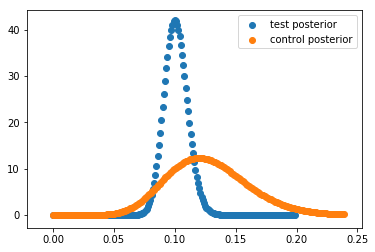

In [39]:
ce = controlled_experiment(Kt,Nt, Kc, Nc)

ce.draw_posterior_distribution()

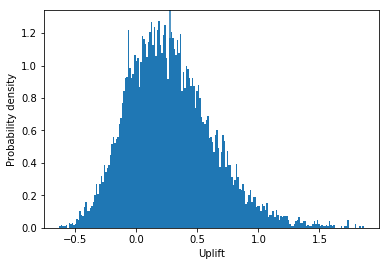

In [40]:
ce.draw_uplift_distribution()

In [41]:
# 60% of the uplift values are below 0.334777
ce.uplift_percentiles([60])

,percentile,value
0,60,0.334777


In [54]:
# Feeding a list yields a dataframe denoting interval of confidence
ce.uplift_percentiles([5,50,95])

,percentile,value
0,5,-0.243900
1,50,0.245449
2,95,0.899833
